In [83]:
'''Created By: Jake Fredrich'''
'''Date: 11/13/2019'''

'Date: 11/13/2019'


# Where in Portland, OR should I purchase a home?

I have several Co-workers that will be visiting a new city, Portland, OR, for several months, working as contractors for IBM.  They plan to rent when they visit Portland, and I would like to help determine the neighborhoods they should consider.
For this, ideally we want to target an area that has a low crime rate, and which has an abundance of venues(that include coffee shops and other venues that are ideal for studying and working), and is not too heavily populated.

To do this analysis, we will use the following information:
For this, ideally we want to target an area that has a low crime rate, and which has an abundance of venues(that include coffee shops and other venues that are ideal for studying), and is not too heavily populated.
To do this analysis, we will use the following information:

<br> 
<ul>
  <li>Crime statistics provided by portlandoregon.gov for 2015-2019</li>
  <li>The population of each each Neighborhood from the 2010 census</li>
  <li>The foursquare api to retrieve the current number and categories of venues in each neighborhood</li>
</ul>
<br> 
Using the above information, we will
<ul>
  <li>Compare crime from 2015 to 2019 to get an idea of which neighborhoods are showing a decline in crime -- and which are therefore also possible candidates to purchase a home</li>
  <li>Look at the proportion of venues/population in each neighborhood</li>
  <li>Cluster neighborhoods to find areas with a relatively high number of venues with a low amount of crime -- therefore possible candidates for a good neighborhood to purchase a home</li>
</ul>
<br> 
<br>

### Data used in this project
<br>

---
<br>
<br>
Crime Statistics of Portland, Oregon(2017, 2018, 2019) https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/comprehensive.cfm
<ul>
  <li>This information will be used to calculate the growth rate of crime</li>
  <li>This data set has 3 columns of interest: Address / Neighborhood/ OccurDate</li>
</ul>
<br> 
Portland, Oregon population datahttps://www.portlandoregon.gov/civic/28387
<br> 
<ul>
  <li>This information includes the Population in each Neighborhood, as shown in the 2010 census.</li>
  <li>this data has two columns of interest: Neighborhood / Population</li>
</ul>
<br>
FourSquare Api:
<ul>
  <li>to get number of pet stores/services per Neighborhood</li>
  <li>specifically, this query will be filtered to look for only the following two </li>categoryIds: [Insert ID]=[Insert Category] , [Insert ID]=[Insert Category]
  <li>a sample query looks like this: https://api.foursquare.com/v2/venues/explore?client_id=</li>
</ul>
<br>

geopy:
<ul>
  <li>to get lat/long coordinates for each Neighborhood, which is used when calling Foursquare API for each Neighborhood</li>
</ul>
<br>
<br>


### IMPORTS

In [84]:
'''IMPORTS REQUIRED'''
#from bs4 import BeautifulSoup # used for pulling data out of HTML and XML files
import json # library to handle JSON files
import numpy as np
import pandas as pd
import requests # library to handle API requests
from pandas.io.json import json_normalize #used to transform the JSON file into a pandas Dataframe

import matplotlib.cm as cm # for plotting modules
import matplotlib.colors as colors # for plotting modules

# Use the inline backend to generate the plots within the browser
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
font = {'size'   : 12}
mpl.rc('font', **font)


import urllib # for plotting modules

from sklearn.cluster import KMeans # import k-means from clustering
#!conda install -c conda-forge geopy --yes 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score

from geopy.geocoders import Nominatim # Used to convert addresses into latitude and longitudes
#!conda install -c conda-forge folium=0.5.0 --yes



# Use Folium to display the Maps for Visualisation
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from folium import plugins

# Module to convert an address into latitude and longitude values
from geopy.geocoders import Nominatim




print("Packages imported")

Packages imported


In [85]:
# save file names
file_2015 = "Final_Data_Sources\Portland_OR_CRIME_2015.csv"
file_2016 = "Final_Data_Sources\Portland_OR_CRIME_2016.csv"
file_2017 = "Final_Data_Sources\Portland_OR_CRIME_2017.csv"
file_2018 = "Final_Data_Sources\Portland_OR_CRIME_2018.csv"
file_2019 = "Final_Data_Sources\Portland_OR_CRIME_2019.csv"

# read in Portland crime files and merge
data_2015 = pd.DataFrame(pd.read_csv(file_2015))#.set_index(["Neighborhood"])
data_2016 = pd.DataFrame(pd.read_csv(file_2016))#.set_index(["Neighborhood"])
data_2017 = pd.DataFrame(pd.read_csv(file_2017))#.set_index(["Neighborhood"])
data_2018 = pd.DataFrame(pd.read_csv(file_2018))#.set_index(["Neighborhood"])
data_2019 = pd.DataFrame(pd.read_csv(file_2019))#.set_index(["Neighborhood"])

# merge all years of Crime data
merged = pd.concat([data_2015, data_2016, data_2017, data_2018, data_2019], join="outer")
merged["Year"] = pd.to_datetime(merged['OccurDate']).dt.year
merged["Month"] = pd.to_datetime(merged['OccurDate']).dt.month
merged['year-month'] = pd.to_datetime(merged['OccurDate']).dt.to_period('M')
merged['hour'] = (merged['OccurTime']/60).round(0)
merged['month_name'] = pd.to_datetime(merged['OccurDate']).dt.month_name()
merged['day_name'] = pd.to_datetime(merged['OccurDate']).dt.day_name()
                              
# remove unnecessary columns
merged = merged.drop(columns=['Address', 'CrimeAgainst', 'OccurTime', 'OccurDate', 'OffenseCount', 'OffenseType',
                             'OpenDataX', 'OpenDataY', 'ReportDate'])
merged.head(2)
#print('Files Merged')

C:\Users\JAKEFREDRICH\Anaconda3\envs\BaseClone\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


CaseNumber  Neighborhood   OffenseCategory  OpenDataLat  OpenDataLon  \
0   15-X197430      Piedmont  Assault Offenses          NaN          NaN   
1  15-X4282999  Buckman West  Assault Offenses          NaN          NaN   

   Year  Month year-month  hour month_name day_name  
0  2015      5    2015-05  23.0        May  Tuesday  
1  2015      5    2015-05  36.0        May   Friday

#### Explore Crime by Neighborhood, Crime by Neighborhood by Year, and Crimbe by Neighborhood by Year dataframe options.  Exploratory only

In [86]:
# Delete rows with year < 2015
N_Crimes = merged
indexNames = N_Crimes[N_Crimes['Year'] < 2015].index
N_Crimes.drop(indexNames , inplace=True)

#Add Yearly Crimes by Neighborhood
N_Crimes = merged.groupby(['Neighborhood', 'Year', 'Month'], as_index=True)['OpenDataLat', 'OpenDataLon'].mean()
N_Crimes['Crime_Count_Month'] = merged.groupby(['Neighborhood', 'Year', 'Month'], as_index=True)['Neighborhood'].count()

#Add Monthly Crimes by Neighborhood
N_Crimes = N_Crimes.reset_index(level='Month') # remove Month index
N_Crimes['Crime_Count_Year'] = N_Crimes.groupby(['Neighborhood', 'Year'], as_index=True)['Crime_Count_Month'].sum()

#Add Total Crimes by Neighborhood
N_Crimes = N_Crimes.reset_index(level='Year') # remove Year index
N_Crimes['Crime_Count_Tot'] = N_Crimes.groupby(['Neighborhood'], as_index=True)['Crime_Count_Month'].sum()

#Fill na values with value above
N_Crimes = N_Crimes.reset_index()
N_Crimes = N_Crimes.sort_values(['Year','Month']).groupby('Neighborhood').ffill()

# Create Percentage of Total Crime for all data by Neighborhood as PoT
Total = merged.shape[0] # Total number of crimes
N_Crimes['PoT'] = (N_Crimes['Crime_Count_Tot']/Total).round(2)

N_Crimes=N_Crimes.sort_values(['Neighborhood','Year','Month'])
N_Crimes.head(100)


Neighborhood  Year  Month  OpenDataLat  OpenDataLon  Crime_Count_Month  \
0       Alameda  2015      2    45.544607          NaN                  1   
1       Alameda  2015      4    45.547488  -122.634315                  2   
2       Alameda  2015      5    45.546467  -122.635415                 10   
3       Alameda  2015      6    45.546280  -122.638390                  9   
4       Alameda  2015      7    45.545738  -122.634525                 15   
5       Alameda  2015      8    45.547640  -122.638024                 20   
6       Alameda  2015      9    45.549976  -122.636762                 12   
7       Alameda  2015     10    45.547812  -122.637566                 16   
8       Alameda  2015     11    45.549064  -122.635524                  8   
9       Alameda  2015     12    45.546685  -122.637033                 11   
10      Alameda  2016      1    45.548996  -122.637033                 10   
11      Alameda  2016      2    45.548054  -122.637033                  7   
12      Alameda  2016      3    45.551176  -122.637033                  9   
13      Alameda  2016      4    45.549467  -122.637033                 11   
14      Alameda  2016      5    45.549040  -122.637033                  9   
15      Alameda  2016      6    45.546455  -122.637033                 10   
16      Alameda  2016      7    45.547692  -122.637033                 14   
17      Alameda  2016      8    45.548778  -122.637033                  6   
18      Alameda  2016      9    45.549883  -122.637033                 14   
19      Alameda  2016     10    45.545816  -122.637033                 18   
20      Alameda  2016     11    45.545743  -122.631191                 11   
21      Alameda  2016     12    45.548793  -122.631204                 17   
22      Alameda  2017      1    45.547306  -122.636340                 10   
23      Alameda  2017      2    45.548360  -122.634752                  9   
24      Alameda  2017      3    45.548494  -122.634021                 15   
25      Alameda  2017      4    45.549062  -122.636139                  7   
26      Alameda  2017      5    45.547628  -122.634377                  9   
27      Alameda  2017      6    45.548884  -122.635035                 12   
28      Alameda  2017      7    45.547777  -122.637103                 10   
29      Alameda  2017      8    45.548667  -122.636900                 15   
..          ...   ...    ...          ...          ...                ...   
70  Arbor Lodge  2016      5    45.572773  -122.681975                 45   
71  Arbor Lodge  2016      6    45.573122  -122.681975                 41   
72  Arbor Lodge  2016      7    45.572780  -122.681975                 32   
73  Arbor Lodge  2016      8    45.573921  -122.703874                 45   
74  Arbor Lodge  2016      9    45.573597  -122.703874                 53   
75  Arbor Lodge  2016     10    45.574096  -122.681975                 65   
76  Arbor Lodge  2016     11    45.574674  -122.682260                 57   
77  Arbor Lodge  2016     12    45.574161  -122.688957                 48   
78  Arbor Lodge  2017      1    45.572635  -122.687401                 34   
79  Arbor Lodge  2017      2    45.574120  -122.685811                 45   
80  Arbor Lodge  2017      3    45.574042  -122.687366                 43   
81  Arbor Lodge  2017      4    45.573552  -122.686288                 44   
82  Arbor Lodge  2017      5    45.573270  -122.688417                 59   
83  Arbor Lodge  2017      6    45.571965  -122.687172                 41   
84  Arbor Lodge  2017      7    45.572516  -122.686472                 46   
85  Arbor Lodge  2017      8    45.573477  -122.686883                 50   
86  Arbor Lodge  2017      9    45.572480  -122.687802                 37   
87  Arbor Lodge  2017     10    45.574242  -122.687813                 54   
88  Arbor Lodge  2017     11    45.572873  -122.691417                 30   
89  Arbor Lodge  2017     12    45.573246  -122.689873                 49   

In [87]:
# Save Month and Year data for charts - counts the number in original dataset
Year_Crimes = merged.groupby('Year').count()
Month_Crimes = merged.groupby('Month').count()/5
print(Month_Crimes)

       CaseNumber  Neighborhood  OffenseCategory  OpenDataLat  OpenDataLon  \
Month                                                                        
1          3811.4        3703.8           3811.4       3430.8       2590.6   
2          3508.2        3411.4           3508.2       3188.6       2404.8   
3          3847.0        3733.8           3847.0       3467.4       2666.4   
4          3870.2        3744.8           3870.2       3491.0       2685.2   
5          4861.0        4724.4           4861.0       4338.0       3548.2   
6          4753.0        4617.2           4753.0       4243.4       3442.0   
7          4838.2        4700.8           4838.2       4359.0       3542.6   
8          4832.2        4694.0           4832.2       4328.6       3481.8   
9          4726.4        4592.4           4726.4       4258.4       3373.2   
10         4068.4        3952.4           4068.4       3653.0       2733.0   
11         3834.2        3709.8           3834.2       3470.6   

Text(0.5, 1.0, 'Count of Cases Per Year in Portland')

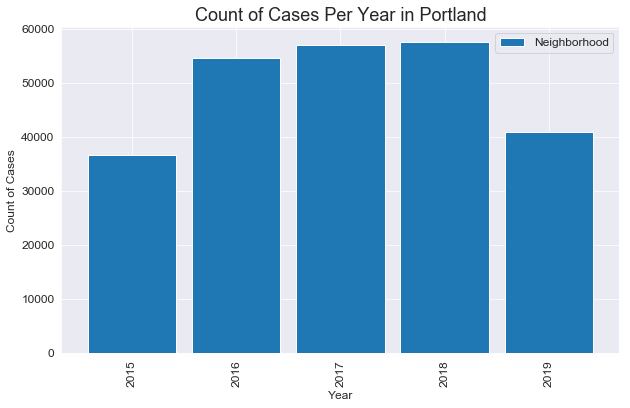

In [88]:
''' CRIME BY YEAR IN PORTLAND OR '''
Year_Crimes['Neighborhood'].plot(y = 'Crime_Count_Year', 
                                      kind='bar',
                                      figsize=(10,6),
                                      width=0.85,
                                      fontsize=12,
                                      colormap='tab20').legend(bbox_to_anchor=(1,1),
                                                               prop={'size': 12})
plt.xlabel('Year')
plt.ylabel('Count of Cases')
plt.title('Count of Cases Per Year in Portland', loc='center', fontsize=18)


## Visualization

Text(0.5, 1.0, 'Avg Cases Per Month in Portland')

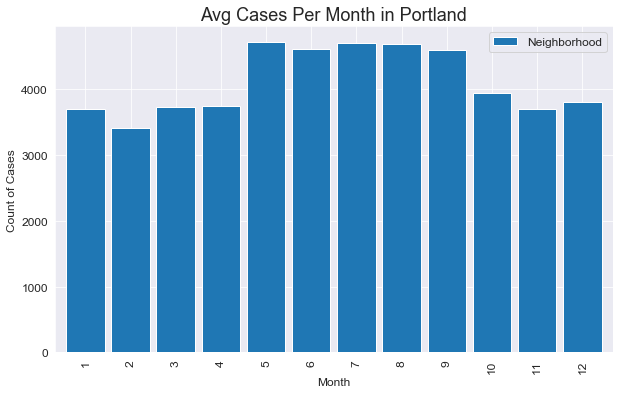

In [89]:
''' CRIME BY MONTH IN PORTLAND OR '''
Month_Crimes['Neighborhood'].plot(y = 'Crime_Count_Month', 
                                      kind='bar',
                                      figsize=(10,6),
                                      width=0.85,
                                      fontsize=12,
                                      colormap='tab20').legend(bbox_to_anchor=(1,1),
                                                               prop={'size': 12})
plt.xlabel('Month')
plt.ylabel('Count of Cases')
plt.title('Avg Cases Per Month in Portland', loc='center', fontsize=18)


In [90]:
N_Crimes['new'] = N_Crimes.groupby(['Year'])['Crime_Count_Tot'].sum()
N_Crimes.head()

Neighborhood  Year  Month  OpenDataLat  OpenDataLon  Crime_Count_Month  \
0      Alameda  2015      2    45.544607          NaN                  1   
1      Alameda  2015      4    45.547488  -122.634315                  2   
2      Alameda  2015      5    45.546467  -122.635415                 10   
3      Alameda  2015      6    45.546280  -122.638390                  9   
4      Alameda  2015      7    45.545738  -122.634525                 15   

   Crime_Count_Year  Crime_Count_Tot  PoT  new  
0               104              627  0.0  NaN  
1               104              627  0.0  NaN  
2               104              627  0.0  NaN  
3               104              627  0.0  NaN  
4               104              627  0.0  NaN

In [91]:
# Number of unique Crime categories based on Offense Category
merged.OffenseCategory.nunique()

24

In [92]:

# What Crimes are the 3 most commonly occuring ones 
merged[['OffenseCategory', 'CaseNumber']].groupby(
    ['OffenseCategory'], as_index=False).count().sort_values(
    'CaseNumber', ascending=False).head(3)



OffenseCategory  CaseNumber
14     Larceny Offenses      107994
2      Assault Offenses       31998
15  Motor Vehicle Theft       27029

In [93]:
# Create a list of the 10 most common crimes
top_crimes = merged[['OffenseCategory', 'CaseNumber']].groupby(
    ['OffenseCategory']).count().sort_values('CaseNumber', ascending=False)[:10].axes[0].tolist()

# Create a list of the 3 most common occuring crimes
top_three_crimes = merged[['OffenseCategory', 'CaseNumber']].groupby(
    ['OffenseCategory']).count().sort_values('CaseNumber', ascending=False)[:3].axes[0].tolist()

# Create a list of the 2 most common occuring crimes
top_two_crimes = merged[['OffenseCategory', 'CaseNumber']].groupby(
    ['OffenseCategory']).count().sort_values('CaseNumber', ascending=False)[:2].axes[0].tolist()



Text(0.5, 1.0, 'Count of Top Crimes Per Year]')

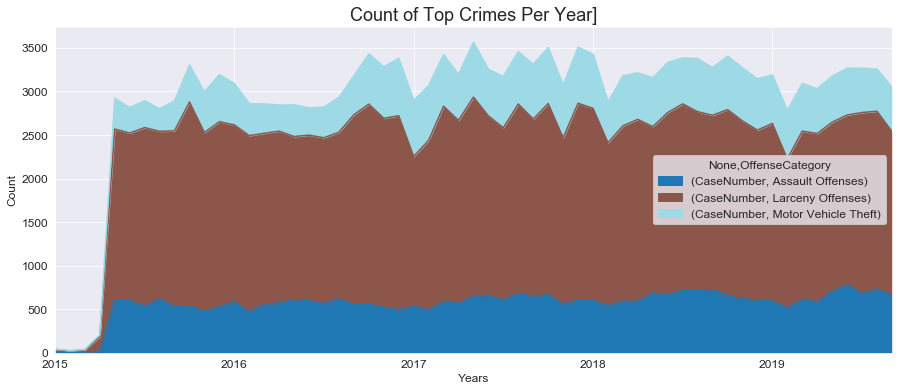

In [94]:

# Create a new data frame with just the top 10 crimes
df_top_crimes = merged[merged['OffenseCategory'].isin(top_crimes)].copy()

# Create a new data frame with just the top 10 crimes
df_top3_crimes = merged[merged['OffenseCategory'].isin(top_three_crimes)].copy()

df_top3_crimes[['CaseNumber', 'OffenseCategory', 'year-month']].pivot_table(
    index='year-month', 
    columns='OffenseCategory', 
    fill_value=0, 
    aggfunc='count').plot(kind='area',
                          stacked=True,
                          figsize=(15, 6),
                               fontsize=12,
                               colormap='tab20')
plt.xlabel('Years')
plt.ylabel('Count')
plt.title('Count of Top Crimes Per Year]', loc='Center', fontsize=18)


# Visualize Top Crimes on Map

In [95]:
df_top_crimes = df_top_crimes.dropna(subset=["OpenDataLat"])
df_top_crimes.dtypes

CaseNumber            object
Neighborhood          object
OffenseCategory       object
OpenDataLat          float64
OpenDataLon          float64
Year                   int64
Month                  int64
year-month         period[M]
hour                 float64
month_name            object
day_name              object
dtype: object

### Create Folium Map with differing colors of crime types

In [96]:
# Create a list of colours. 
# We have  list of the top 10 crimes from earlier
colors = [
    'red',
    'blue',
    'gray',
    'orange',
    'beige',
    'green',
    'purple',
    'pink',
    'cadetblue',
    'black'
]

# Create a dictionary of colours to map to the crimes
dict_colors = dict(zip(top_crimes, colors))

# Add the colours colums to the df_top_crimes DataFrame
df_top_crimes['color'] = df_top_crimes.OffenseCategory.map(dict_colors)



There are too many points to disply effeciently using Folium. We will use May 2019 data.


In [97]:
df_top_crimes_may19 = df_top_crimes[(df_top_crimes.Month == 3) & (df_top_crimes.Year == 2019)]

# Pickle the DataFrame to Separate the Folium Maps into a Separate Notepad
df_top_crimes_may19.to_pickle('crimes_may19.pkl')

In [98]:
# Define Portland's geolocation coordinates
Portland_latitude = 45.52345  
Portland_longitude = -122.67621


# Define the world map centered around Chicago with a higher zoom level
Portland_map = folium.Map(location=[Portland_latitude, Portland_longitude], zoom_start=11)

# display world map
Portland_map

# Instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, col in zip(df_top_crimes_may19.OpenDataLat, 
                         df_top_crimes_may19.OpenDataLon, 
                         df_top_crimes_may19.color):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=1, # define how big you want the circle markers to be
            color=col,
            fill=True,
            fill_color=col,
            fill_opacity=0.6
        )
    )

# add incidents to map
Portland_map.add_child(incidents)

In [99]:
print("Hello")

Hello


In [100]:
mc = MarkerCluster()

# Define the world map centered around Chicago with a higher zoom level
Portland_cluster = folium.Map(location=[Portland_latitude, Portland_longitude], zoom_start=11)

# display world map
Portland_cluster

#creating a Marker for each point in df_sample. Each point will get a popup with their zip
for row in df_top_crimes_may19.itertuples():
    mc.add_child(folium.Marker(
        location=[row.OpenDataLat,  row.OpenDataLon],
                 popup=row.OffenseCategory))

Portland_cluster.add_child(mc)
Portland_cluster

In [101]:

from folium import plugins
from folium.plugins import HeatMap

Portland_heatmat = folium.Map(location=[Portland_latitude, Portland_longitude], zoom_start=11) 

# List comprehension to make out list of lists
heat_data = [[row['OpenDataLat'], 
              row['OpenDataLon']] for index, row in df_top_crimes_may19.iterrows()]

# Plot it on the map
HeatMap(heat_data,
        min_opacity=0.5,
        max_zoom=18, 
        max_val=1.0, 
        radius=15,
        blur=20,
        gradient=None,
        overlay=True).add_to(Portland_heatmat)

# Display the map
Portland_heatmat



In [111]:
df_top_crimes = df_top_crimes[df_top_crimes['Year'] == 2018]#.reset_index() #all the years has too much data. Reduce to 2018
df_top_crimes['Ward'] = pd.factorize(df_top_crimes['Neighborhood'])[0] + 1

df_top_crimes.head(10)

index CaseNumber Neighborhood        OffenseCategory  OpenDataLat  \
0   5444   18-54394          NaN                Robbery    45.523103   
1   5445  18-233111          NaN    Motor Vehicle Theft    45.523103   
2   5446  18-389315          NaN                Robbery    45.523103   
3   5447  18-904817        Kerns       Larceny Offenses    45.523038   
4   5448  18-681013          NaN       Larceny Offenses    45.597045   
5   5449    18-9818          NaN  Weapon Law Violations    45.517618   
6   5450  18-427668        Boise       Larceny Offenses    45.549575   
7   5451  18-904586        Boise       Larceny Offenses    45.549575   
8   5452  18-334919        Eliot       Larceny Offenses    45.535138   
9   5453  18-150269     Piedmont       Assault Offenses    45.573272   

   OpenDataLon  Year  Month year-month  hour month_name  day_name  color  Ward  
0  -122.668684  2018      2    2018-02  35.0   February  Thursday   pink     0  
1  -122.668684  2018      7    2018-07  15.0       July    Sunday   gray     0  
2  -122.668684  2018     11    2018-11  36.0   November   Tuesday   pink     0  
3  -122.665583  2018      3    2018-03  23.0      March  Saturday    red     1  
4  -122.607332  2018      6    2018-06  31.0       June    Monday    red     0  
5  -122.669002  2018      1    2018-01  36.0    January   Tuesday  black     0  
6  -122.667025  2018     12    2018-12  21.0   December   Tuesday    red     2  
7  -122.667025  2018      3    2018-03  37.0      March    Friday    red     2  
8  -122.666884  2018      9    2018-09  22.0  September    Sunday    red     3  
9  -122.667282  2018      5    2018-05  26.0        May    Sunday   blue     4

## Data Preparation for Modelling

Modeling requires that we use only numberical data, and remove uneeded columns.

We will remove Categorical Data Types and replace them with One Hot encoding. The Dependant Variables will be Normalized and Principal Component Analysis will be used to reduce the dimensionality of the DF.


In [112]:
# Start by copying the Latitude and Longitude to the new DataFrame
df_features = df_top_crimes[['OpenDataLat', 'OpenDataLon']]

# Next and One Hot Encoding of the hour, day and month variables
df_features = df_features.join(pd.get_dummies(df_top_crimes.hour, prefix='hour'))
df_features = df_features.join(pd.get_dummies(df_top_crimes.day_name))
df_features = df_features.join(pd.get_dummies(df_top_crimes.month_name))


# Finally add the ward & crimes column, copied from the original Primary Description column
df_features['Ward'] = df_top_crimes[['Ward']]
df_features['crimes'] = df_top_crimes[['OffenseCategory']]


In [113]:
df_features.head()

OpenDataLat  OpenDataLon  hour_0.0  hour_1.0  hour_2.0  hour_3.0  hour_4.0  \
0    45.523103  -122.668684         0         0         0         0         0   
1    45.523103  -122.668684         0         0         0         0         0   
2    45.523103  -122.668684         0         0         0         0         0   
3    45.523038  -122.665583         0         0         0         0         0   
4    45.597045  -122.607332         0         0         0         0         0   

   hour_5.0  hour_6.0  hour_7.0  ...  January  July  June  March  May  \
0         0         0         0  ...        0     0     0      0    0   
1         0         0         0  ...        0     1     0      0    0   
2         0         0         0  ...        0     0     0      0    0   
3         0         0         0  ...        0     0     0      1    0   
4         0         0         0  ...        0     0     1      0    0   

   November  October  September  Ward               crimes  
0         0        0          0     0              Robbery  
1         0        0          0     0  Motor Vehicle Theft  
2         1        0          0     0              Robbery  
3         0        0          0     1     Larceny Offenses  
4         0        0          0     0     Larceny Offenses  

[5 rows x 63 columns]

In [114]:
# Create a smaller DataFrame of only the top three crimes
df_features_three = df_features[df_features['crimes'].isin(top_three_crimes)].copy()

# Create a smaller DataFrame of only the top two crimes
df_features_two = df_features[df_features['crimes'].isin(top_two_crimes)].copy()

In [115]:
#  Create the X, dependant variables, DataFrames by dropping the Crimes column
X_10 = df_features.copy()
y_10 = X_10.crimes.values

X_10.drop('crimes', axis=1, inplace=True)
X_10 = preprocessing.StandardScaler().fit(X_10).transform(X_10)


X_3 = df_features_three.copy()
y_3 = X_3.crimes.values

X_3.drop('crimes', axis=1, inplace=True)
X_3 = preprocessing.StandardScaler().fit(X_3).transform(X_3)

X_2 = df_features_two.copy()
y_2 = X_2.crimes.values

X_2.drop('crimes', axis=1, inplace=True)
X_2 = preprocessing.StandardScaler().fit(X_2).transform(X_2)

C:\Users\JAKEFREDRICH\Anaconda3\envs\BaseClone\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\JAKEFREDRICH\Anaconda3\envs\BaseClone\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\JAKEFREDRICH\Anaconda3\envs\BaseClone\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\JAKEFREDRICH\Anaconda3\envs\BaseClone\lib\site-packages\ipykernel_launcher.py:13: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  del sys.path[0]
C:\Users\JAKEFREDRICH\Anaconda3\envs\BaseClone\lib\site-packages\sklea

In [116]:
# Set X = X_10
X = X_10
y = y_10

In [117]:
# Set X = X_3
X = X_3
y = y_3


In [118]:
# Set X = X_2
X = X_2
y = y_2

#### K Nearest Neighbor(KNN)
###### Find the best K to build

In [123]:
from datetime import datetime
def cross_validate(model, n_splits = 10):
    
    k_fold = KFold(n_splits = n_splits)
    scores = [model.fit(X[train], y[train]).score(X[test], y[test]) for train, test in k_fold.split(X)]
    
    scores = np.percentile(scores, [40, 50, 60])
    return scores

Neighbours:  5   2019-11-14 09:12:06.668395
Neighbours:  6   2019-11-14 09:12:50.452504
Neighbours:  7   2019-11-14 09:13:34.734185
Neighbours:  8   2019-11-14 09:14:19.455991
Neighbours:  9   2019-11-14 09:15:04.326697
Neighbours:  10   2019-11-14 09:15:51.144528
Neighbours:  11   2019-11-14 09:16:36.957339


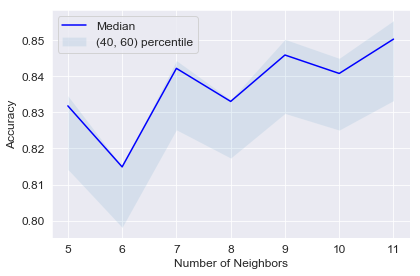

In [124]:
# Number of neighbours
neighs = range(5, 12)

# Store the scores
scores = np.zeros((len(neighs), 3))

for idx, neigh in enumerate(neighs):
    print('Neighbours: ', neigh, ' ', str(pd.datetime.now()))
    model = KNeighborsClassifier(n_neighbors = neigh)
    scores[idx, : ] = cross_validate(model, n_splits = 5)

plt.plot(neighs, scores[ : , 1], 'b')
plt.fill_between(neighs, scores[ : , 0], scores[:, 2], alpha = 0.1)
plt.legend(('Median', '(40, 60) percentile'))
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors')
plt.tight_layout()
plt.show()